In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# <center>Last regression</center>
<center><img src=https://media0.giphy.com/media/l0K4k1O7RJSghST3a/giphy.gif></center>

Last time we have seen that changing the interpretation of the output of a perceptron leads us to values that are representing a probability of belonging to a certain class `{0,1}`. This is especially usefull whenever the data is cursed with noise or is not linearly separable straightforwardly. This has led to new definition of Sigmoid activation function.

Although we change the interpretation itself, what remains unaltered is the way we treat the `net_output` of the network $\vec{W}\cdot \vec{X} + b$. We can now clearly see that it is usually the main component of any network and things that change so far are only:
- dimensionality
- activation function -> thus the gradient (or the Hessian for second order optimization)
- loss functions
- interpretation of the output itself

In the perceptron the goal is to minimize the missclassification. In the case of logistic regression, the goal is to maximize the `likelihood` using below output as probability: 

$$ p(\vec{W}, \vec{X}) = \frac{1}{1 + e^{-W\cdot X}}.$$

What kind of probability distribution is this? Conditional or not?

We know that the outputs of the network should be independent and therefore it corresponds to a binomial conditional distribution. This is indeed visible as $y=0,1$:

$$P(\vec{y}|\vec{W};\vec{X})= \prod _ i  p^{y^{i}}(1-p)^{1-y^{i}}.$$

Multiplying each of those probabilities and taking the logarithm of the whole gives us the loss function:

$$ L = -\sum _i [y^i\log p_i + (1-y^i)\log(1-p_i)].$$

Notice that minus is taken in order to minimize, not maximize, the loss itself. If we write:

$$ \sigma(z) = \frac{1}{1 + e^{-z}}, $$

then the partial derivative of the loss function is given by:

$$ \frac{\partial L}{\partial w_k} = \sum _i y_i \frac{\partial p_i}{\partial w_k} \left[\frac{y_i}{p_i} - \frac{1-y_i}{1-p_i}\right],$$

with:

$$ \sigma '(z) = \sigma(z)^2 e^{-z} = \sigma(z) * \frac{1 + e^{-z} - 1}{1+e^{-z}} = \sigma(z) \left(1 - \frac{1}{1+e^{-z}}\right) = \sigma(z) \left(1-\sigma(z)\right). $$

Therefore, what we obtain is:

$$ \frac{\partial L}{\partial w_k} = \sum _i y_i \sigma(W\cdot X)\left(1-\sigma(W\cdot X)\right) \left[\frac{y_i}{\sigma(W\cdot X)} - \frac{1-y_i}{1-\sigma(W\cdot X)}\right] \cdot \partial _{w_k} (W\cdot X).$$

This finaly leads us to:

$$ \nabla _W L = \sum _i^{\text{batch}} \left [y_i - \sigma (W\cdot X_i)\right]X_i$$

#### Look at the finished example of the perceptron used as a logistic regressor.

 Take a second to think what has changed. Ask questions if necessary. Make sure that you understand what is crucial in the algorithm. Has it changed much compared to the linear perceptron gradient look?

##### OLD CLASSES

In [2]:
class Perceptron:
    # Initialize the bias and the dimension of the perceptron. 
    def __init__(self, W : np.array,  b = 0):
        self.W = W
        self.N = len(W)
        self.b = b
    
    ############################## GETTERS ##############################
    
    def get_N(self):
        return self.N
    
    def get_b(self):
        return self.b
    
    def get_W(self):
        return self.W
    
    ############################## SETTERS ##############################
    
    # Create setters for the perceptron
    def set_N(self, N):
        self.N = N
        self.W = np.zeros(N)
        
    def set_b(self, b):
        self.b = b
        
    def set_W(self, W : np.array):
        if W.ndim != 1:
            print("Cannot set such weights -> dimension wrong")
            return
        self.N = W.shape[0]
        self.W = W
    
    ############################## GETTERS OVERRIDE ##############################
    
    def __getitem__(self, key):
        return self.W[key]
    
    def __setitem__(self, key, value):
        self.W[key] = value
        
    def __getslice(self, i, j):
        return self.W[i:j]
    
    # set the string output of the perceptron 
    def __str__(self):
        return f"Am a perceptron of N={self.N} dimension{'s' if self.N > 1 else ''} biased with b={self.b}"    

    ############################## OPERATORS OVERRIDE ##############################
     
    def __mul__(self, other):
        return self.activation_function(other)
    
    def __rmul__(self, other):
        return self.__mul__(other)

    ############################## PERCEPTRON METHODS ##############################
    
    '''
    Net output is the basic body action of the perceptron. On top of it, the activation function is used.
    '''
    def net_output(self, X):
        return np.dot(X, self.W) + self.b
    
    '''
    Here the activation function is step-like
    '''
    def activation_function(self, X):
        return np.where(self.net_output(X) >= 0.0, 1.0, 0.0).reshape((len(X),1))
   
    '''
    Predicts the output of perceptron -> here the class is given   
    '''
    def predict(self, X):
        return self.activation_function(X)      

In [3]:
class PerceptronLinear(Perceptron):
    # Initialize the bias and the dimension of the perceptron -> but not only that
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        super().__init__(W, b)
        # how many learning iterations we give
        self.epo = epo
        # what is our step in the gradient
        self.lr = lr
    
    ############################## GETTERS ##############################

    def get_lr(self):
        return self.lr

    def get_epo(self):
        return self.epo
    
    ############################## SETTERS ##############################
    
    def set_lr(self, lr):
        self.lr = lr
        
    def set_epo(self, epo):
        self.epo = epo

    ############################## PERCEPTRON METHODS ##############################
    '''
    As you can see the activation function has been changed to linear regression. What does reshape do?
    After you figure it out, note that it is the usual way of having the output of the machine learning algorithm. Why?
    '''
    def activation_function(self, X):
        return (self.net_output(X)).reshape(-1,1)
    
    '''
    Loss function for the perceptron -> here we use the Mean Square Error
    '''           
    def loss(self, y_true : np.array, y_pred : np.array):
        square = np.square(y_true - y_pred)
        return np.mean(square)
    
    '''
    Single step of the gradient, here it is calculated analytically (linear regression)
    '''
    def gradient(self, x_true, y_true, prediction):
        delta_i = (y_true.flatten() - prediction)
        suma_w = np.multiply(delta_i[:, np.newaxis], x_true)
        suma_b = delta_i         
        return suma_b, suma_w
    
    '''
    Fit function allows to obtain the (probably most?) correct weights for the perceptron via the gradient descent algorithm.
    '''
    def fit(self, X, y, randomstate = None, batch = 1, verbose = False):
        
        if type(X) != np.ndarray:
            X = np.array(X)
        if type(y) != np.ndarray:
            y = np.array(y).reshape(-1,1)
            
        # give fit the parameter randomstate and whenever it is not None, the weights
        # are reset to be random normal - this ensures random starting point of gradient descent
        if randomstate is not None:
            self.W = np.random.normal(0.0, 0.1, self.N)
            self.b = np.random.normal(0.0, 1.0)
        
        # Save the history of the losses. Why?
        history = []
        # If we want to calculate the gradient in buckets (look for description of the batch)
        bucket_num = len(X) // batch
        # slice the data onto batches without shuffling (no stochasticity)
        slicing = lambda x, b: x[(b-1)*batch:b*batch]
        
        # iterate epochs
        for epo in range(self.epo):
            # iterate batches
            loss = 0.0
            for bin in range(1, bucket_num + 1):
                X_slice = slicing(X,bin)
                y_slice = slicing(y,bin)
                # predict the output for a given slice (what is the shape of the output?)
                pred = self.predict(X_slice)
                
                suma_b, suma_w = self.gradient(X_slice, y_slice, pred.flatten())

                # calculate loss
                loss += self.loss(y_slice, pred.flatten())
                
                # update the weights
                self.W += np.mean(suma_w, axis = 0) * self.lr
                self.b += np.mean(suma_b, axis = 0) * self.lr 
            # calculate average loss
            loss/=bucket_num
            if verbose:
                print(f'epo:{epo}->loss={loss}')        
            history.append(loss.flatten())
        return np.array(history).flatten()
    '''
    Basic history plot
    '''        
    def plot_history(self, history, ax = None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.set_xlabel('epo')
        ax.set_ylabel('loss')
        ax.plot(history)

In [4]:
class PerceptronBinary(PerceptronLinear):
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        super().__init__(W, b, epo, lr)
        
    '''
    $\Phi(x) = sign(x)
    '''
    def activation_function(self, X):
        return np.where(self.net_output(X) >= 0.0, 1.0, -1.0).reshape(-1,1)
    
    '''
    Loss function for the perceptron -> here we use knowledge that the classes can be either {-1, 1}
    '''           
    def loss(self, y_true : np.array, y_pred : np.array):
        square = np.square(1.0-y_true * y_pred)
        return np.mean(square)
    
    '''
    Single step of the gradient, here it is calculatable analytically (linear regression)
    '''
    def gradient(self, x_true, y_true, prediction):
        val = np.multiply(y_true, (1.0-y_true * prediction))
        suma_w = np.multiply(val, x_true)
        suma_b = val         
        return suma_b, suma_w

##### NEW CLASS

In [6]:
class PerceptronLogistic(PerceptronBinary):
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        super().__init__(W, b, epo, lr)

    def activation_function(self, X):
        return (1.0/(1.0+np.exp(-self.net_output(X)))).reshape(-1,1)

    def loss(self, y_true : np.array, y_pred : np.array):
        return -np.sum(np.multiply(y_true, np.log(y_pred)) + np.multiply((1.0-y_true), np.log(1.0-y_pred)))

    def gradient(self, x_true, y_true, prediction):
        val = y_true - prediction
        suma_w = np.multiply(val, x_true)
        suma_b = val         
        return suma_b, suma_w

### a) Use the below data to test the finished logistic regression. See the probability corespondence?

In [7]:
# data
X = (np.concatenate((np.random.uniform(low=-2.0, high=0.4, size=50), np.random.uniform(low=-0.4, high=3.0, size=50)))).reshape(-1,1)
Y = np.array([0]*50 + [1]*50).reshape(-1,1)


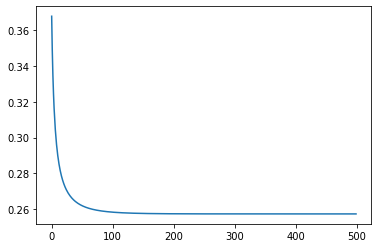

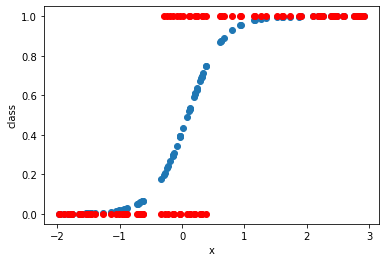

In [20]:
# fit the perceptron
p=PerceptronLogistic([1],0.1,500,0.01)
history=# fit the perceptron
# plot the history
Y_pred = # predict the output
plt.show()

# plotting data and prediction
plt.scatter(X,Y_pred)
plt.scatter(X,Y,c='red')
plt.xlabel('x')
plt.ylabel('class')
plt.show()

Additionally, we can use the Newton's method in order to find the minimum of logistic regressor quicker. We remember that in this second order gradient method we implement:

$$ \vec{W} \leftarrow W - H^{-1} \nabla _{\vec{W}} \vec{L}(\vec{W}),$$

where $\nabla _{\vec{W}} \vec{L}(\vec{W})$ is the vector of partial derivatives of the cost function with respect to $W$ and $H$ a $n\times n$ matrix (or ($n+1 \times n+1$) with bias included) called the Hessian such that:

$$ H_{ij} = \frac{\partial ^2 L(\vec{W})}{\partial w_i \partial w_j}.$$


In the case of logistic regression calculating the second derivative is easy as:

$$ \partial _{w_k} L = \sum _i^{\text{batch}} \left [y_i - \sigma (W\cdot X_i)\right]x^k_i,$$

and therefore:

$$ \partial _{w_k} \partial _{w_l} L = -\sum _i^{\text{batch}} \sigma (W\cdot X_i) \left[1 -\sigma (W\cdot X_i)\right] x^k_i x^l_i,$$


##### [`DISCLAIMER`] Sometimes it is necessary to use some regularization of the hessian as it may be not invertable due to high condition number at the begining of the learning procedure. One can either add a very small number that is becoming smaller at each step or use the [pseudo inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse).

#### b) Implement the correct Hessian using the class below and test it on the same data.

In [16]:
class PerceptronLogistic_v2(PerceptronBinary):
    def __init__(self, W : np.array,  b = 0, epo = 100, lr = 0.01):
        super().__init__(W, b, epo, lr)

    '''
    Sigmoid - plot it if you want to
    '''
    def activation_function(self, X):
        return (1.0/(1.0+np.exp(-self.net_output(X)))).reshape(-1,1)

    '''
    Maximal likelyhood loss
    '''
    def loss(self, y_true : np.array, y_pred : np.array):
        return -np.sum(np.multiply(y_true, np.log(y_pred)) + np.multiply((1.0-y_true), np.log(1.0-y_pred)))
    
    '''
    Is of the same character as linear regression
    '''
    def gradient(self, x_true, y_true, prediction):
        val = y_true - prediction
        suma_w = np.multiply(val, x_true)
        suma_b = val         
        return suma_b, suma_w
    
    '''
    Calculates the hessian using logistic regression sigmoid activation
    - x_true : input of the model (for convinience in flattened version)
    - y_true : supervised learning true classes
    - y_pred : predictions of the model for a given batch
    '''
    def hessian(self, x_true, y_true, y_pred):
        hess = np.zeros((len(x_true) + 1, len(x_true) + 1))
        
        # we add 1 because of the bias
        for i in range(len(x_true) + 1):
            # taking bias into account
            xi = 1 if i == 0 else x_true[i-1]
            for j in range(len(x_true) + 1):
                # taking bias into accoutn
                xj = 1 if j == 0 else x_true[j-1]
                
                # add small number to hessian
                #if i == j:
                #    hess[i,j] += 1e-4
                
                # what is the Hessian? Look up
                hess[i,j] += 
                
        return hess
    
    '''
    Newton rap : https://www.youtube.com/watch?v=8yis7GzlXNM
    '''
    def newton_rap(self, X, y, randomstate = None, verbose = False):        
        if type(X) != np.ndarray:
            X = np.array(X)
        if type(y) != np.ndarray:
            y = np.array(y).reshape(-1,1)
            
        # give fit the parameter randomstate and whenever it is not None, the weights
        # are reset to be random normal - this ensures random starting point of gradient descent
        if randomstate is not None:
            self.W = np.random.normal(0.0, 0.1, self.N)
            self.b = np.random.normal(0.0, 1.0)
        
        # Save the history of the losses. Why?
        history = []

        # iterate epochs
        for epo in range(self.epo):
            # iterate batches
            loss = 0.0
            for i, X_slice in enumerate(X):
                # take the slice (therefore a single batch)
                y_slice = y[i]
                # predict the output for a given slice (what is the shape of the output?)
                pred = self.predict(X_slice)
                # calculate the gradient
                suma_b, suma_w = self.gradient(X_slice, y_slice, pred.flatten())
                # flatten it to calculate the hessian (shape convinience)
                grad = np.array(list(suma_b.flatten()) + list(suma_w.flatten()))
                # calculate the hessian
                hessian = # calculate the hessian, flatten the prediction please
                # calculate the update vector
                update = # calculate the Penrose pseudoinverse and calculate the dot product with the gradient
                # update weights
                self.W += np.array(self.lr*update[1:])
                self.b += np.array(self.lr*update[0])
                # calculate loss
                loss += self.loss(y_slice, pred.flatten())
                
            if verbose:
                print(f'epo:{epo}->loss={loss}')        
            history.append(loss.flatten())
        return np.array(history).flatten()

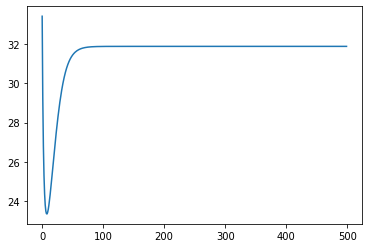

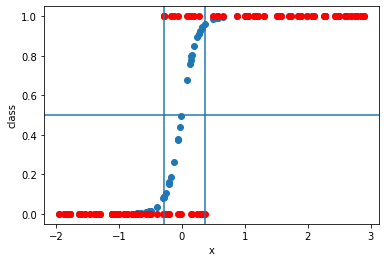

In [25]:
# data
X = (np.concatenate((np.random.uniform(low=-2.0, high=0.4, size=50), np.random.uniform(low=-0.4, high=3.0, size=50)))).reshape(-1,1)
Y = np.array([0]*50 + [1]*50).reshape(-1,1)

# fit the perceptron
p=PerceptronLogistic_v2([1],0.1, 500, lr = 2e-4)
history= # use new function newton_rap
# plot the history
Y_pred = # predict the output
plt.show()

# plotting data and prediction
plt.scatter(X,Y_pred)
plt.scatter(X,Y,c='red')
plt.axhline(0.5)
plt.axvline(np.min(X[Y==1]))
plt.axvline(np.max(X[Y==0]))
plt.xlabel('x')
plt.ylabel('class')
plt.show()

All the previous information about the regularization still hold for this model.

# <center>Support Vector Machines</center>
<center><img src=https://media.giphy.com/media/TSmahCISxIiZ2/giphy.gif></center>

Sometimes in the classification algorithms we are not quite sure about the true outcome or what the classifying line should be. Furthermore, certainly world is not linear in most of the cases and we would like to classify nonlinear data as well. 

Support vector machine algorithm contains all the capabilities to work effectively in high dimensional spaces, even when the number of dimensions is greater than the number of samples. In order to achieve non-linearity it uses the kernel fucntions to transform the data onto higher dimensional spaces and then provide new support vectors. It is crucial to use the correct kernel in SVM.

Let us start with the linear decision line. The decision line is again defined as before, with the bias excluded from the vector $\vec{W}$. 

#### a) Create a random two-dimensional weights vector and plot the decision line for different biases.

Note that again $\vec{W}$ is the vector of weights (now $[w_0,w_1]$) and decision line is given by points that give us $$\vec{W} \cdot {\vec{X}} + b = 0.$$

What we need to find then is a perpendicular vector to $\vec{W}$. This vector shall cross the y axis at a specific point. You can use the reasoning below:

$$ w_0 x_0 + w_1 x_1 + b = 0 \rightarrow \{x_0 \equiv 0 \} \rightarrow c \equiv -b/w_1, $$

will be our crossing point c.

But we know that for the decision line $x_1 = a x_0 + c$.

Then, to find the slope $a$, we again use the function defining the decision line

$$ w_0 x_0 + w_1 (a * x_0 - b/w_1) + b = 0 \rightarrow a \equiv - w_0 / w_1$$

`Especially plot the corresponding decision lines`: $$\vec{W} \cdot {\vec{X}} + b = \pm 1.$$

How do they correspond to the support vectors and certainity of the prediction.

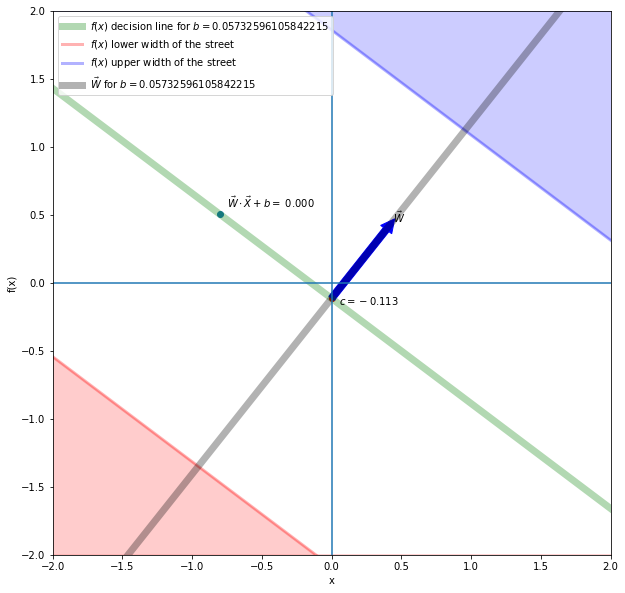

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
# set b
b = np.random.random() / 10
b1 = b+1
b2 = b-1
# set the random vector
W = # define the random vector

# define the calculated points
c = # calculate c from above
c1 = # calcuate c corresponding to b1
c2 = # calculate c corresponding to b2
a = # calculate the slope of the linear function

# perpendicular function to W
fp=lambda x: a * x + c
fp1=lambda x: a * x + c1
fp2=lambda x: a * x + c2

# a function for parallel function to W (contains the vector W)
f=# define the function that is perpendicular to fp but crosses the point y=c at x=0

# set xrange
x = np.arange(-2.5, 2.5, 0.11)

# plot decision function
ax.plot(x,fp(x), 
         color = 'green', alpha = 0.3, linewidth=7,
         label = f'$f(x)$ decision line for $b=$'+str(b))
ax.plot(x,fp1(x), linestyle = '-',
         color = 'red', alpha = 0.3, linewidth=3,
         label = f'$f(x)$ lower width of the street')
ax.fill_between(x, -2, fp1(x), color = 'red', alpha = 0.2)
ax.plot(x,fp2(x),linestyle = '-',
         color = 'blue', alpha = 0.3, linewidth=3,
         label = f'$f(x)$ upper width of the street')
ax.fill_between(x, fp2(x), 2, color = 'blue', alpha = 0.2)
# plot the weights function
ax.plot(x,f(x),
         color = 'black', alpha = 0.3, linewidth=7,
         label = r'$\vec{W}$ for $b=$'+str(b))

# plot labels
ax.text(W[0] + 0.05, W[1] + 0.05 + c, r'$\vec{W}$')
ax.text(0+0.05, c-0.05, f"$c={c:.3f}$")
ax.scatter(0, c, color = 'red')

# plot W vector
ax.arrow(0, c, W[0], W[1], head_width = 0.1, width = 0.05,
          head_length=0.1, color = 'blue')

# check condition W * X laying on f(x) + b = 0
xp = -0.8
yp = fp(xp)
ax.scatter(xp,yp)
ax.text(xp+0.05, yp+0.05, r'$\vec{W}\cdot \vec{X} + b=$'+f'{xp*W[0] + yp*W[1] + b : .3f}')

# axes
ax.axhline(0)
ax.axvline(0)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()

In the algorithm, the idea of the loss function is again somewhat different. We start from an arbitrary point $\vec{u}$ that needs to be classified. The decision is made to ensure that:

$$ \frac{\vec{W}}{||W||} \cdot \vec{u} > d \rightarrow \text{+}$$
$$ \frac{\vec{W}}{||W||} \cdot \vec{u} < d \rightarrow \text{--}$$

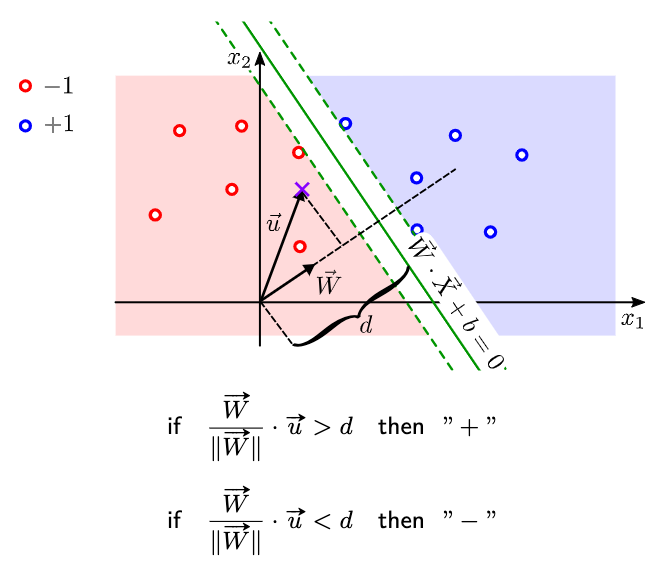

The norm of the vector and the coefficient can be then reinterpreted to be:

$$ b = -d ||W||,$$ 

and thus we have our bias back in,

$$ \vec{W} \cdot \vec{u} +b > 0 \rightarrow \text{+}$$
$$ \vec{W} \cdot \vec{u} +b < 0 \rightarrow \text{--}$$

and therefore we obtain our line decision rule from above: points above or below the line are given +1, -1, respectively. 

On our plot above, we have also ploted two lines parallel to the decision lines. They define some kind of margin $\lambda$, which was equal to 1 for our case. The choice of $\lambda$ is arbitrary (cf. the lecture) so the choice of 1 seems to be the simplest one. The margin shall be then optimized with the bias and the weights.

Including the margin, what we then assume is the decision for our predictor to be:

$$ \vec{W} \cdot \vec{X_+} + b \geq 1, $$
$$ \vec{W} \cdot \vec{X_-} + b \leq -1.$$

The two classes $\pm$ can be replaced by labels $\pm 1$. Then, independently of whether $\vec{X_i}$ is $\vec{X_+}$ or $\vec{X_-}$, one gets a simple inequality for the correct classification

$$ y_i (\vec{W} \cdot \vec{X}_i + b) \geq 1 $$

and `support vectors` are defined to be the vectors for which above inequality becomes an equality. 

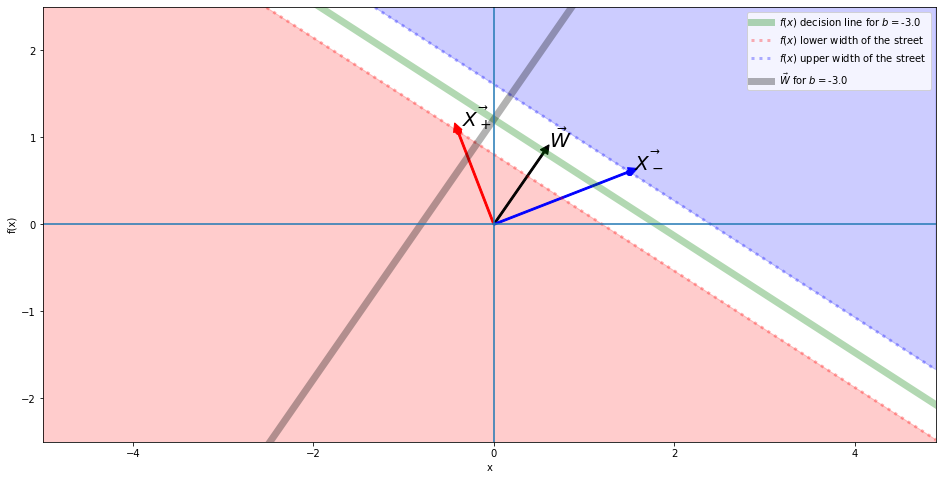

In [31]:
fig, ax = plt.subplots(figsize=(16,8))
# set b
b = -3.0
b1 = b+1
b2 = b-1
# set the random vector
W = np.random.random(2) * 4

# define the calculated points
c = -b/W[1]
c1 = -b1/W[1]
c2 = -b2/W[1]
a = -W[0]/W[1]

# perpendicular function to W
fp=lambda x: a * x + c
fp1=lambda x: a * x + c1
fp2=lambda x: a * x + c2

# a function for parallel function to W (contains the vector W)
f=lambda x: -1.0/a * x + c

# set xrange
x = np.arange(-5, 5, 0.11)

# plot decision function
ax.plot(x,fp(x), 
         color = 'green', alpha = 0.3, linewidth=7,
         label = f'$f(x)$ decision line for $b=$'+str(b))
ax.plot(x,fp1(x), linestyle = ':',
         color = 'red', alpha = 0.3, linewidth=3,
         label = f'$f(x)$ lower width of the street')
ax.fill_between(x, x.min(), fp1(x), color = 'red', alpha = 0.2)
ax.plot(x,fp2(x),linestyle = ':',
         color = 'blue', alpha = 0.3, linewidth=3,
         label = f'$f(x)$ upper width of the street')
ax.fill_between(x, fp2(x), x.max(), color = 'blue', alpha = 0.2)

# plot the weights function
ax.plot(x,f(x),
         color = 'black', alpha = 0.3, linewidth=7,
         label = r'$\vec{W}$ for $b=$'+str(b))


# plot W vector
norm = np.sqrt(np.sum(np.square(W)))
ax.arrow(0, 0, W[0]/norm, W[1]/norm, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'black')
# plot labels
ax.text(W[0]/norm + 0.05, W[1]/norm + 0.05, r'$\vec{W}$', fontsize=20)

# check condition W * X laying on f(x) + b = 0
xp1 = -0.4
xp2 = 1.5
yp1 = fp1(xp1)
yp2 = fp2(xp2)
ax.scatter(xp1,yp1, color = 'red')
ax.scatter(xp2,yp2, color = 'blue')

# plot the support vectors
ax.arrow(0, 0, xp1, yp1, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'red')
ax.text(xp1 + 0.05, yp1 + 0.05, r'$\vec{X_+}$', fontsize=20)
ax.arrow(0, 0, xp2, yp2, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'blue')
ax.text(xp2 + 0.05, yp2 + 0.05, r'$\vec{X_-}$', fontsize=20)


# axes
ax.axhline(0)
ax.axvline(0)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-2.5, 2.5)
plt.legend()

The width of the street is then calculated to know the confidence:

$$ \text{width} = (\vec{X}_+ - \vec{X}_-)\cdot \frac{\vec{W}}{||W||}. $$

Using previous equations we obtain the equations for both vectors:

$$ W\cdot X_+ = 1-b \quad (y_i = 1) \quad \& \quad W\cdot X_- = -1 -b \quad (y_i = -1). $$

The optimal position of the separating hyperplane is the widest street. Therefore what we need to do is to minimize the magnitude of the weight vector $\vec{W}$. This has been shown during the lecture with solution via the Lagrange multipliers subject to constraints:

$$ \min _{\vec{W}} ||\vec{W} ||^2,  \quad y_i (\vec{W} \cdot \vec{X_i} + b) \geq 1 \quad \text{for each sample}.$$ 


The Lagrange function is therfore like a loss function for us. Nevertheless, what we do is we maximize it analytically by finding the 0 of the first derivatives of the Langrange function:

$$ L(\vec{W}, b, \vec{\alpha}) = \frac{1}{2} ||\vec{W}||^2 - \sum _i \alpha _i \left[y_i (\vec{W}\cdot \vec{X} + b)-1\right] .$$

Taking the derivatives $\partial _{w_k}, \partial _b$ of the Lagrange function and equating them to 0 we obtain:
$$ \sum _i \alpha _i y_i = 0.$$
$$ \vec{W} = \sum _i \alpha _i y_i \vec{X} _i. $$   

The bias is then reobtained from the constraint equation inputting the vector $\vec{W}$ into:
$$ y_i (\vec{W} \cdot \vec{X} _i + b ) = 1. $$ 

This gives us (cf. lecture):
$$ b = y_i - \vec{W} \cdot \vec{X} _i, $$

where $X_i$ is any of the support vectors. 

Inserting all of the equations back into the Lagrangian  gives us the functional that only needs to be minimized with respect to $\alpha$'s and is based on the dot products of each of the support vectors $\vec{X}_i$. 

$$ L(\vec{\alpha}) = \sum _i \alpha _i - \frac{1}{2} \sum _{i,j} \alpha _i \alpha _j y_i y_j \vec{X}_i\cdot \vec{X} _j. $$

##### [`REMARK`] Keep track of this equation and the dot product in it as it is very important later for nonlinear data.

#### b) Take the data below and analytically find the solution of the Lagrange problem. 
- Plot the data and plot the corresponding support vectors. 
- Plot the weights vector and the street. 
- Calculate the width of the street. 
- Experiment with adding a third point to the data.

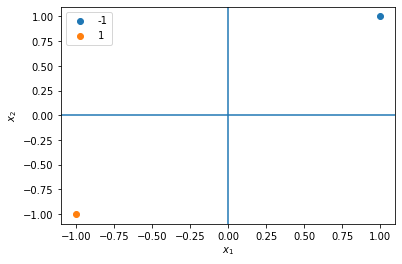

In [32]:
X_1 = np.array([1,1])
Y_1 = -1
X_2 = np.array([-1,-1])
Y_2 = 1
plt.scatter(X_1[0], X_1[1], label = Y_1)
plt.scatter(X_2[0], X_2[1], label = Y_2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axvline(0)
plt.axhline(0)
plt.legend()

$$ X_1\cdot X_1 = 2 $$
$$ X_1 \cdot X_2 = -2 $$
$$ X_2 \cdot X_1 = -2 $$
$$ X_2 \cdot X_2 = 2 $$

$$ L(\vec{a}) = a _ 1 + a _ 2 - 1/2 * ... $$

and therefore:

$$ L = ??? $$ 

$$a_1 = ?, a_2 = ?$$

In [551]:
# W = \sum _i a_i y_i X_i
a_1 = 
a_2 =  
W = 
print(f'W={W}')
norm_w = np.sqrt(np.sum(np.square(W)))
print(f'norm={norm_w}')
b = # calculate b for any of the support vectors
print(f'b={b}')
width = # calculate the width
print(f'width={width}', r'width/$2\sqrt{2}=$' + f'{width / (2*np.sqrt(2))}')


SyntaxError: invalid syntax (722505394.py, line 2)

#### Use the previous plot functions to plot the necessary tasks

0.0 -1.0


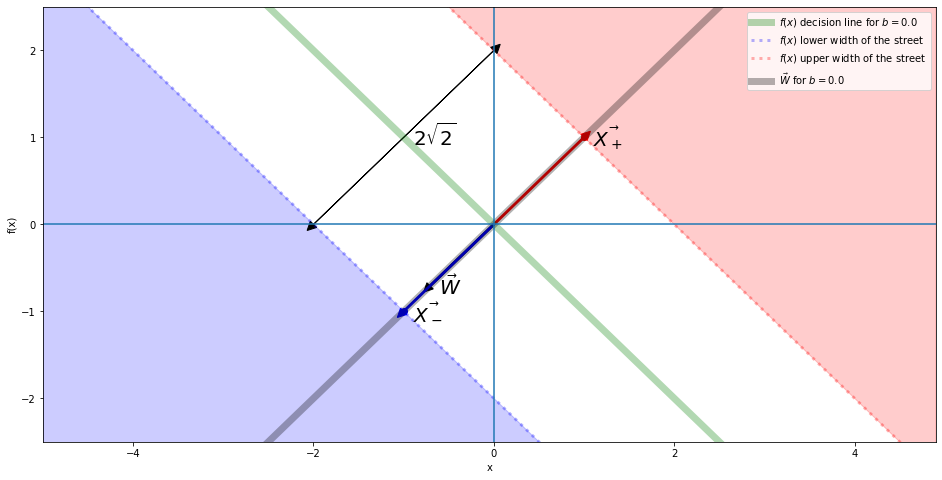

In [537]:
fig, ax = plt.subplots(figsize=(16,8))

# define the calculated points
c = -b/W[1]
a = -W[0]/W[1]
print(c,a)

# perpendicular function to W
fp=lambda x: a * x + c
fp1=lambda x: a * (x-X_2[0]) + c + X_2[1] 
fp2=lambda x: a * (x-X_1[0]) + c + X_1[1] 

# a function for parallel function to W (contains the vector W)
f=lambda x: -1.0/a * x + c

# set xrange
x = np.arange(-5, 5, 0.11)

# plot decision function
ax.plot(x,fp(x), 
         color = 'green', alpha = 0.3, linewidth=7,
         label = f'$f(x)$ decision line for $b=$'+str(b))
ax.plot(x,fp1(x), linestyle = ':',
         color = 'blue', alpha = 0.3, linewidth=3,
         label = f'$f(x)$ lower width of the street')
ax.fill_between(x, x.min(), fp1(x), color = 'blue', alpha = 0.2)
ax.plot(x,fp2(x),linestyle = ':',
         color = 'red', alpha = 0.3, linewidth=3,
         label = f'$f(x)$ upper width of the street')
ax.fill_between(x, fp2(x), x.max(), color = 'red', alpha = 0.2)

# plot the weights function
ax.plot(x,f(x),
         color = 'black', alpha = 0.3, linewidth=7,
         label = r'$\vec{W}$ for $b=$'+str(b))


# plot W vector
norm = np.sqrt(np.sum(np.square(W)))
ax.arrow(0, 0, W[0]/norm, W[1]/norm, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'black')
# plot labels
ax.text(W[0]/norm + 0.1, W[1]/norm - 0.1, r'$\vec{W}$', fontsize=20)

# to plot width
x_width = -1.0
y_width = fp(x_width)
dx_width = X_2[0]
dy_width = X_2[1]
ax.arrow(x_width, y_width, dx_width, dy_width, head_width = 0.1,
          head_length=0.1, color = 'black')
dx_width = X_1[0]
dy_width = X_1[1]
ax.arrow(x_width, y_width, dx_width, dy_width, head_width = 0.1,
          head_length=0.1, color = 'black')
ax.text(x_width+ 0.1, y_width - 0.1,r'$2\sqrt {2}$', fontsize=20)


# check condition W * X laying on f(x) + b = 0
xp1 = X_1[0]
xp2 = X_2[0]
yp1 = X_1[1]
yp2 = X_2[1]
ax.scatter(xp1,yp1, color = 'red')
ax.scatter(xp2,yp2, color = 'blue')

# plot the support vectors
ax.arrow(0, 0, xp1, yp1, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'red')
ax.text(xp1 + 0.1, yp1 - 0.1, r'$\vec{X_+}$', fontsize=20)
ax.arrow(0, 0, xp2, yp2, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'blue')
ax.text(xp2 + 0.1, yp2 - 0.1, r'$\vec{X_-}$', fontsize=20)


# axes
ax.axhline(0)
ax.axvline(0)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-2.5, 2.5)
plt.legend()

#### c) Do the same but use the numerical method to maximize the Lagrangian function. 
You can use the scipy library, which implements [optimization minimizer](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Define Lagrange function to be $-L(\vec{W})$ in order to find the maximum. 

#### Lagrange function definition

In [538]:
'''
Note that the Lagrange function has minus at the beginning in order to use the scipy.optimize.minimize function.
'''
def Lagrange(alphas : np.ndarray, Y : np.ndarray, X : np.ndarray):
    .
    .
    .
    return 


Text(0.5, 1.0, 'Value of Lagrange function for different $\\alpha$.')

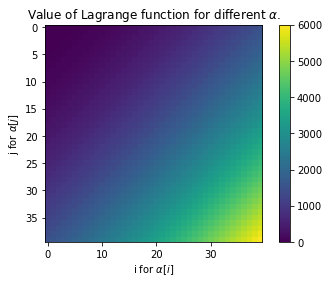

In [539]:
from scipy import optimize

# concatenate the vectors and outputs
X = np.array([X_1, X_2])
Y = np.array([Y_1, Y_2])

# plot the corresponding Lagrange function as an image to find the minimum visualy 
a_test = np.arange(-2, 2, 0.1)
data = np.zeros((len(a_test), len(a_test), 1))
for i,vi in enumerate(a_test):
    for j,vj in enumerate(a_test):
        data[i,j] = Lagrange([i,j], Y, X) 

c = plt.imshow(data)
plt.colorbar(c)
plt.ylabel(r'j for $\alpha[j]$')
plt.xlabel(r'i for $\alpha[i]$')
plt.title(r"Value of Lagrange function for different $\alpha$.")

#### Define the constraint with [scipy.optimize.LinearConstraint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.LinearConstraint.html#scipy.optimize.LinearConstraint)

In [540]:
# define the constraint
constraint = 


#### Optimize and get the values of $\vec{\alpha}$

In [541]:
x = # use the minimize function on Lagrange function with constraints
alphas = 
alphas

array([0.25, 0.25])

#### Get $\vec{W}$.

In [542]:
W = alphas[0] * X[0] * Y[0] + alphas[1] * X[1] * Y[1]
W

array([-0.5, -0.5])

#### Get the bias $b$.

In [543]:
b = Y_1 - W.dot(X_1)
b

4.440892098500626e-16

#### Plot it!

<center><img src=https://media.tenor.com/7EttrztgjiAAAAAC/palpatine-star-wars.gif></center>

8.881784197001248e-16 -1.0


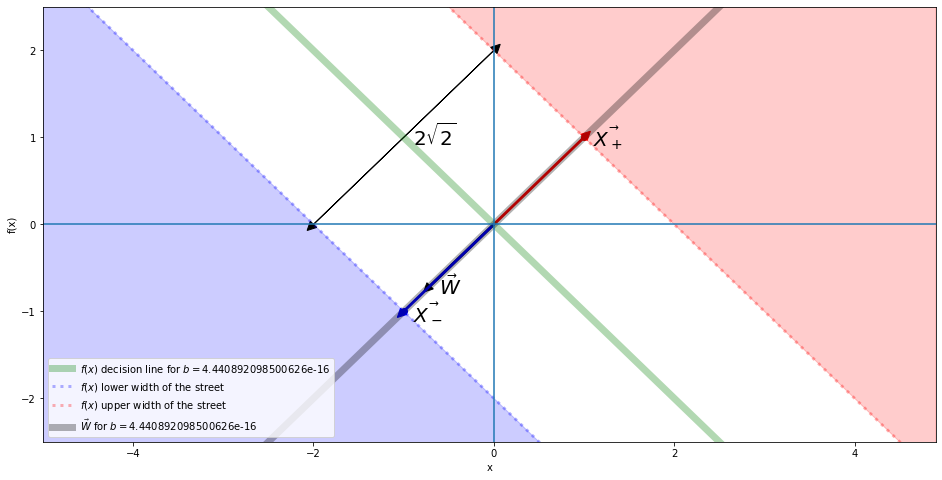

In [544]:
fig, ax = plt.subplots(figsize=(16,8))

# define the calculated points
c = -b/W[1]
a = -W[0]/W[1]
print(c,a)

# perpendicular function to W
fp=lambda x: a * x + c
fp1=lambda x: a * (x-X_2[0]) + c + X_2[1] 
fp2=lambda x: a * (x-X_1[0]) + c + X_1[1] 

# a function for parallel function to W (contains the vector W)
f=lambda x: -1.0/a * x + c

# set xrange
x = np.arange(-5, 5, 0.11)

# plot decision function
ax.plot(x,fp(x), 
         color = 'green', alpha = 0.3, linewidth=7,
         label = f'$f(x)$ decision line for $b=$'+str(b))
ax.plot(x,fp1(x), linestyle = ':',
         color = 'blue', alpha = 0.3, linewidth=3,
         label = f'$f(x)$ lower width of the street')
ax.fill_between(x, x.min(), fp1(x), color = 'blue', alpha = 0.2)
ax.plot(x,fp2(x),linestyle = ':',
         color = 'red', alpha = 0.3, linewidth=3,
         label = f'$f(x)$ upper width of the street')
ax.fill_between(x, fp2(x), x.max(), color = 'red', alpha = 0.2)

# plot the weights function
ax.plot(x,f(x),
         color = 'black', alpha = 0.3, linewidth=7,
         label = r'$\vec{W}$ for $b=$'+str(b))


# plot W vector
norm = np.sqrt(np.sum(np.square(W)))
ax.arrow(0, 0, W[0]/norm, W[1]/norm, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'black')
# plot labels
ax.text(W[0]/norm + 0.1, W[1]/norm - 0.1, r'$\vec{W}$', fontsize=20)

# to plot width
x_width = -1.0
y_width = fp(x_width)
dx_width = X_2[0]
dy_width = X_2[1]
ax.arrow(x_width, y_width, dx_width, dy_width, head_width = 0.1,
          head_length=0.1, color = 'black')
dx_width = X_1[0]
dy_width = X_1[1]
ax.arrow(x_width, y_width, dx_width, dy_width, head_width = 0.1,
          head_length=0.1, color = 'black')
ax.text(x_width+ 0.1, y_width - 0.1,r'$2\sqrt {2}$', fontsize=20)


# check condition W * X laying on f(x) + b = 0
xp1 = X_1[0]
xp2 = X_2[0]
yp1 = X_1[1]
yp2 = X_2[1]
ax.scatter(xp1,yp1, color = 'red')
ax.scatter(xp2,yp2, color = 'blue')

# plot the support vectors
ax.arrow(0, 0, xp1, yp1, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'red')
ax.text(xp1 + 0.1, yp1 - 0.1, r'$\vec{X_+}$', fontsize=20)
ax.arrow(0, 0, xp2, yp2, head_width = 0.1, width = 0.02,
          head_length=0.1, color = 'blue')
ax.text(xp2 + 0.1, yp2 - 0.1, r'$\vec{X_-}$', fontsize=20)


# axes\7EttrztgjiAAAAAC\palpatine-star-wars.gif
ax.axhline(0)
ax.axvline(0)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-2.5, 2.5)
plt.legend()

<center><img src=https://media.tenor.com/z1whwYBZy84AAAAC/emperor-palpatine-the-dark-side-of-the-force.gif></center>


# <center>`TO BE CONTINUED`</center>